Sampling Finished in 3.695 seconds
Log Evidence: -80.853
Posterior mean: [ 4.96442511 10.63929187]


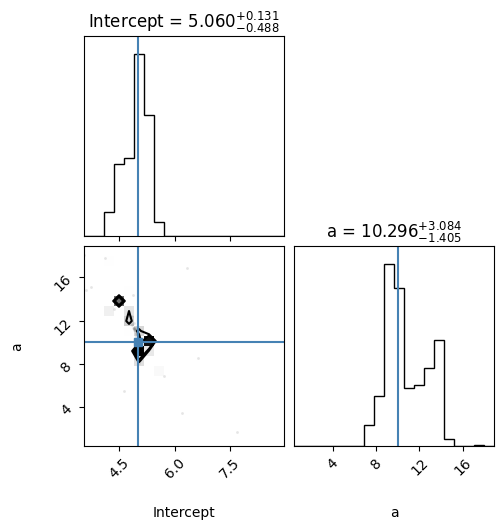

In [3]:
import sys
from pynest import NestedSampler
import numpy as np
import matplotlib.pyplot as plt
mean = 0
dev = 5
def simulate_data(a,b,n):
    x = np.linspace(0,10,n)
    y = a*x + b + np.random.normal(loc=mean,scale=dev,size=n)
    return x,y

x, y = simulate_data(5,10,25)

def log_gaussian(x, mu, sig):
    return np.log(1/np.sqrt(2 * np.pi * sig**2.0))  +  (-0.5/sig**2.0) * (x - mu)**2.0

def myloglike(cube):
    log_likelihood = 0
    for i in tuple(zip(x,y)):
        log_likelihood += log_gaussian(i[1], cube[0]*i[0] + cube[1], dev)
    return log_likelihood

def myprior(cube):
    cube[0] = cube[0] * 10
    cube[1] = cube[1] * 20
    return cube

sampler = NestedSampler(log_likelihood=myloglike, prior=myprior, ndim = 2, max_iterations=50)
sampler.run()
sampler.summary()
sampler.plot_posterior(labels=['Intercept','a','b'], truths=[5,10])


In [27]:
import pandas as pd

data = pd.DataFrame({"x":x,"y":y})
data.to_csv('simulated_data.csv',index=False)

In [6]:
param1 = np.linspace(0,20,100)
param1_likval = [myloglike([5,param]) for param in param1]

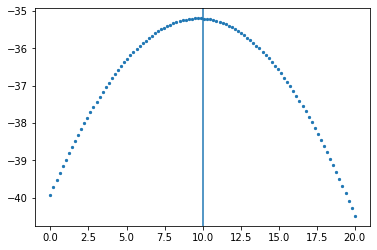

In [7]:
plt.scatter(param1,param1_likval,s=5)
plt.axvline(10)

In [8]:
param2 = np.linspace(0,10,100)
param2_likval = [myloglike([param,10]) for param in param2]

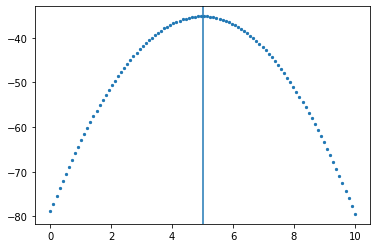

In [9]:
plt.scatter(param2,param2_likval,s=5)
plt.axvline(5)

In [10]:
np.random.normal(loc=0,scale=10)

0.6816069482110201

In [11]:
sampler = Sampler(log_likelihood=myloglike, prior=myprior, ndim = 2, sample_method = 'mcmc')
sampler.sample()

cube [0.8323846976627834, 0.1530297184106909] [8.323846976627834, 3.060594368213818]
Initial Upper Bound -36.046472276323335 -0.2 -36.24647227632334
New upper bound -36.046472276323335 -0.4 -36.446472276323334 0.0
New upper bound -36.046472276323335 -0.6 -36.64647227632334 0.0
New upper bound -36.046472276323335 -0.8 -36.84647227632333 0.0
New upper bound -36.046472276323335 -1.0 -37.046472276323335 0.0
New upper bound -36.046472276323335 -1.2 -37.24647227632334 0.0
New upper bound -36.046472276323335 -1.4 -37.446472276323334 0.0
New upper bound -36.046472276323335 -1.6 -37.64647227632334 0.0
New upper bound -36.046472276323335 -1.8 -37.84647227632333 0.0
New upper bound -36.046472276323335 -2.0 -38.046472276323335 0.0
New upper bound -36.046472276323335 -2.2 -38.24647227632334 0.0
New upper bound -36.046472276323335 -2.4 -38.446472276323334 0.0
New upper bound -36.046472276323335 -2.6 -38.64647227632334 0.0
New upper bound -36.046472276323335 -2.8 -38.84647227632333 0.0
New upper boun

KeyboardInterrupt: 

In [29]:
pymultinest.run(myloglike, myprior, 2, outputfiles_basename='./1-',resume = False, verbose = True)

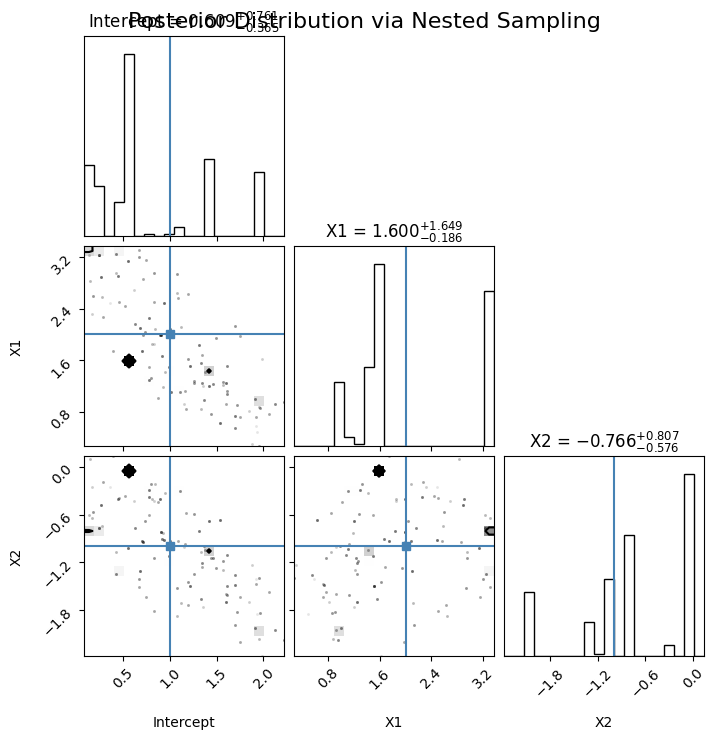

Log evidence (ln Z): -173.6675327241324
Posterior mean: [ 0.78206386  2.01986635 -0.73474337]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import corner
from scipy.stats import multivariate_normal

# --- Generate synthetic data ---
np.random.seed(42)
N = 20
X = np.random.rand(N, 2)
X = np.hstack([np.ones((N, 1)), X])  # Add intercept term
true_w = np.array([1.0, 2.0, -1.0])
sigma = 0.1
y = X @ true_w + np.random.randn(N) * sigma

# --- Prior and likelihood ---
D = X.shape[1]
prior_mean = np.zeros(D)
prior_cov = np.eye(D) * 10

def log_prior(w):
    return multivariate_normal.logpdf(w, mean=prior_mean, cov=prior_cov)

def log_likelihood(w):
    pred = X @ w
    return -0.5 * np.sum((y - pred)**2) / sigma**2 - N * np.log(np.sqrt(2 * np.pi) * sigma)

# --- Nested sampling ---
n_live = 100
live_points = np.random.multivariate_normal(prior_mean, prior_cov, size=n_live)
log_likes = np.array([log_likelihood(w) for w in live_points])
Z = 0.0
H = 0.0
samples = []

log_X = 0.0
for i in range(500):
    i_min = np.argmin(log_likes)
    worst = live_points[i_min]
    L_min = log_likes[i_min]

    log_X_new = log_X - 1.0 / n_live
    weight = np.exp(log_X) - np.exp(log_X_new)
    Z += np.exp(L_min) * weight
    H += np.exp(L_min) * weight * (L_min - np.log(Z + 1e-300))
    samples.append((worst, np.exp(L_min) * weight))

    # Replace worst point with new sample > L_min
    while True:
        w_new = np.random.multivariate_normal(prior_mean, prior_cov)
        if log_likelihood(w_new) > L_min:
            break
    live_points[i_min] = w_new
    log_likes[i_min] = log_likelihood(w_new)
    log_X = log_X_new

# --- Posterior samples ---
posterior_ws = np.array([s[0] for s in samples])
weights = np.array([s[1] for s in samples])
weights /= np.sum(weights)

# --- Corner plot ---
corner.corner(
    posterior_ws,
    weights=weights,
    labels=["Intercept", "X1", "X2"],
    truths=true_w,
    show_titles=True,
    title_fmt=".3f",
    title_kwargs={"fontsize": 12}
)
plt.suptitle("Posterior Distribution via Nested Sampling", fontsize=16)
plt.show()

# --- Evidence output ---
print("Log evidence (ln Z):", np.log(Z))
print("Posterior mean:", np.average(posterior_ws, axis=0, weights=weights))
